# First

In [ ]:
import numpy as np
import pandas as pd
import time

from stable_baselines3 import PPO, SAC, TD3, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# import your wrapper
from ot2_gym_wrapper import OT2Env

def make_env():
    env = OT2Env(render=False, max_steps=1000, tol=0.001, action_limit=1.5, sim_steps_per_action=8)
    env = Monitor(env)
    return env

ALGORITHMS = {
    "PPO": PPO,
    "SAC": SAC,
    "TD3": TD3,
    "A2C": A2C,
}

TRAIN_STEPS = 200_000
EVAL_EPISODES = 20

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


**Since the action space is continuous the algorithms taken into consideration are ([RL tips and tricks](https://araffin.github.io/slides/rlvs-tips-tricks/#/16)):**

**1. PPO (Proximal Policy Optimization)**

Why consider PPO:

PPO is one of the most widely used on-policy algorithms for continuous control tasks. It is known for its training stability, robustness to hyperparameter choices, and reliable convergence behavior. It handles continuous action spaces naturally (velocity commands in x/y/z), stable learning even with imperfect reward shaping and it is often used as a baseline algorithm in robotics and control benchmarks.

**2. SAC (Soft Actor-Critic)**

Why consider SAC:

SAC is an off-policy algorithm that maximizes both reward and policy entropy, encouraging exploration. It is one of the most sample-efficient algorithms for continuous control. SAC well suited for continuous state/action robotics problems, often converges faster than on-policy methods and it's high exploration helps avoid local minima near the target.

**3. TD3 (Twin Delayed DDPG)**

Why consider TD3:

TD3 is an improved deterministic policy gradient method designed to address instability and overestimation bias in earlier algorithms like DDPG. It is designed specifically for continuous control, produces smooth, deterministic actions (important for precise positioning) and often achieves very accurate final positioning.

**4. A2C (Advantage Actor-Critic)**

Why consider A2C:

A2C is a simpler, synchronous actor-critic algorithm that is computationally lightweight and easy to train. It is easy to debug and interpret, has lower computational cost, serves as a contrast to more advanced algorithms and it is good baseline for understanding how algorithm complexity affects performance.

In [15]:
results = []

for name, Algo in ALGORITHMS.items():
    print(f"\n=== Training {name} ===")

    env = make_env()

    model = Algo(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0001
    )

    model.learn(total_timesteps=TRAIN_STEPS)

    # evaluation
    mean_reward, std_reward = evaluate_policy(
        model,
        env,
        n_eval_episodes=EVAL_EPISODES,
        deterministic=True,
        return_episode_rewards=False
    )

    # custom metrics
    episode_lengths = []
    final_dists = []
    steps_to_success = []
    successes = 0
    wall_hits = 0
    total_oob_steps = 0

    for _ in range(EVAL_EPISODES):
        obs, _ = env.reset()
        done = False
        step = 0
        episode_oob = False

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step += 1

            # track out-of-bounds steps
            if info.get("out_of_bounds", False):
                episode_oob = True
                total_oob_steps += 1
        
        episode_lengths.append(step)
        final_dists.append(info["dist"])
        if info["dist"] < env.env.tol:
            successes += 1
            steps_to_success.append(step)

        if episode_oob:
            wall_hits += 1

    results.append({
        "Algorithm": name,
        "Mean Reward": mean_reward,
        "Success Count": successes,
        "Success Rate": successes / EVAL_EPISODES,
        "Mean Final Distance": np.mean(final_dists),
        "Mean Steps (success only)": np.mean(steps_to_success) if steps_to_success else np.nan,
        "Mean Episode Length": float(np.mean(episode_lengths)) if episode_lengths else np.nan,
        "Episodes with Wall Hit": wall_hits,
        "Wall Hit Rate": wall_hits / EVAL_EPISODES,
        "Total OOB Steps": total_oob_steps,
    })

    env.close()


=== Training PPO ===
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -108     |
| time/              |          |
|    fps             | 2281     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -160        |
| time/                   |             |
|    fps                  | 1525        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005032913 |
|    clip_fraction        | 0.00884     |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       

In [16]:
df = pd.DataFrame(results)
df

Algorithm  Mean Reward  Success Count  Success Rate  Mean Final Distance  \
0       PPO  -164.262777              0           0.0             0.167704   
1       SAC   -50.693667              0           0.0             0.130318   
2       TD3   -21.798501              0           0.0             0.154444   
3       A2C   -29.602225              0           0.0             0.215718   

   Mean Steps (success only)  Mean Episode Length  Episodes with Wall Hit  \
0                        NaN              1000.00                       0   
1                        NaN               574.35                      11   
2                        NaN               111.85                      20   
3                        NaN               110.00                      20   

   Wall Hit Rate  Total OOB Steps  
0           0.00                0  
1           0.55               11  
2           1.00               20  
3           1.00               20

array([<Axes: title={'center': 'Success Rate'}, xlabel='Algorithm'>,
       <Axes: title={'center': 'Mean Final Distance'}, xlabel='Algorithm'>,
       <Axes: title={'center': 'Success Count'}, xlabel='Algorithm'>],
      dtype=object)

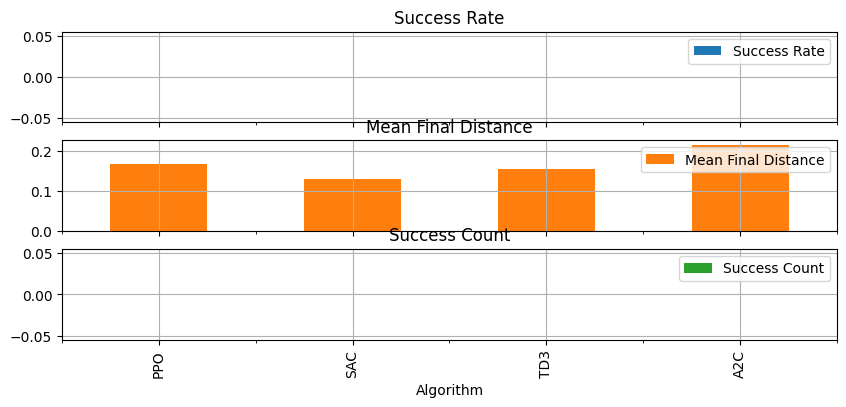

In [17]:
df.set_index("Algorithm")[["Success Rate", "Mean Final Distance", "Success Count"]].plot(
    kind="bar", subplots=True, figsize=(10,4), grid=True
)

In [ ]:
df = pd.DataFrame(results)

if (df["Success Rate"] == 0).all():
    best_row = df.sort_values("Mean Final Distance", ascending=True).iloc[0]
else:
    best_row = df.sort_values(["Success Rate", "Mean Final Distance"], ascending=[False, True]).iloc[0]

best_algo_name = best_row["Algorithm"]
print("Best algorithm:", best_algo_name)


  Algorithm  Mean Reward  Success Count  Success Rate  Mean Final Distance  \
0       PPO  -164.262777              0           0.0             0.167704   
1       SAC   -50.693667              0           0.0             0.130318   
2       TD3   -21.798501              0           0.0             0.154444   
3       A2C   -29.602225              0           0.0             0.215718   

   Mean Steps (success only)  Mean Episode Length  Episodes with Wall Hit  \
0                        NaN              1000.00                       0   
1                        NaN               574.35                      11   
2                        NaN               111.85                      20   
3                        NaN               110.00                      20   

   Wall Hit Rate  Total OOB Steps  
0           0.00                0  
1           0.55               11  
2           1.00               20  
3           1.00               20  
Best algorithm: SAC


In [2]:
ALGORITHMS = {
    "PPO": PPO,
    "SAC": SAC,
    "TD3": TD3,
    "A2C": A2C,
}

# BestAlgo = ALGORITHMS[best_algo_name]
BestAlgo = SAC

In [3]:
BestAlgo

stable_baselines3.sac.sac.SAC

In [21]:
# import wandb

# def make_env():
#     env = OT2Env(render=False, max_steps=1000, tol=1e-3)
#     env = Monitor(env)
#     return env

# # --- Wandb run config ---
# config = {
#     "algo": best_algo_name,
#     "total_timesteps": 300_000,
#     "learning_rate": 0.0001,
#     "env_name": "OT2Env",
#     "max_steps": 1000,
# }

# run = wandb.init(
#     entity="242621-breda-university-of-applied-sciences",
#     project="ot2-rl-243552",      # choose your project name on wandb
#     config=config,
# )

# env = make_env()

# model = BestAlgo(
#     "MlpPolicy",
#     env,
#     verbose=1,
#     learning_rate=config["learning_rate"]
# )

https://stable-baselines3.readthedocs.io/en/master/modules/sac.html

In [ ]:
sweep_config = {
    "method": "bayes",   # or "random"
    "metric": {
        "name": "eval/success_rate",
        "goal": "maximize",
    },
    "parameters": {
        # Actor–critic learning rate
        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 1e-4,
            "max": 2e-4   # default is 3e-4
        },

        # Discount factor
        "gamma": {
            "values": [0.98, 0.99]
        },

        # Batch sizes: SAC likes big values
        "batch_size": {
            "values": [256, 512]   # default 256
        },

        # Soft target update coefficient
        "tau": {
            "values": [0.005, 0.01]    # default 0.005
        },

        # Entropy coefficient (exploration intensity)
        "ent_coef": {
            "values": ["auto_1.0"]
        },

        # When to start training
        "learning_starts": {
            "values": [1000, 5000]       # default 1000
        },

        # How often and how much to update policy
        "train_freq": {
            "values": [1, 2]               # default 1
        },

        "gradient_steps": {
            "values": [2, 4]               # default 1
        },
        
        "target_entropy": {
            "values": ["auto", -2]},
    },
}

In [5]:
from stable_baselines3.common.callbacks import BaseCallback

class WallTimeoutCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.wall_hits = 0
        self.timeouts = 0
        self.steps = 0

    def _on_step(self):
        infos = self.locals.get("infos", [])
        for info in infos:
            if info.get("out_of_bounds"):
                self.wall_hits += 1
            if info.get("timeout"):
                self.timeouts += 1
        self.steps += len(infos)
        return True

    def _on_rollout_end(self):
        if self.steps:
            self.logger.record("custom/out_of_bounds_rate", self.wall_hits / self.steps)
            self.logger.record("custom/timeout_step_rate", self.timeouts / self.steps)
        self.wall_hits = self.timeouts = self.steps = 0


In [6]:
import wandb
from wandb.integration.sb3 import WandbCallback

EVAL_EPISODES = 50
total_timesteps = 30_000

def sweep_train(total_timesteps=total_timesteps):
    run = wandb.init(
        entity="242621-breda-university-of-applied-sciences",
        project="ot2-rl-243552-full",
        config={  # defaults/extra fields; sweep params will override these
            "total_timesteps": total_timesteps,
            "algo": "SAC",
            # optional explicit defaults for sweep keys
            "learning_rate": 3e-4,
            "gamma": 0.99,
            "batch_size": 256,
            "tau": 0.005,
            "ent_coef": "auto",
            "learning_starts": 1000,
            "train_freq": 1,
            "gradient_steps": 1,
            "target_entropy": "auto",
        },
        sync_tensorboard=True,
        monitor_gym=True,
        settings=wandb.Settings(symlink=False),
)
    config = wandb.config

    env = make_env()

    model = BestAlgo(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=config.learning_rate,
        gamma=config.gamma,
        batch_size=config.batch_size,
        tau=config.tau,
        ent_coef=config.ent_coef,
        learning_starts=config.learning_starts,
        train_freq=config.train_freq,
        gradient_steps=config.gradient_steps,
        seed=42,
        tensorboard_log=f"runs/{run.id}",
    )

    callbacks = [WandbCallback(log="all", verbose=1), WallTimeoutCallback()]

    model.learn(
        total_timesteps=total_timesteps,
        callback=callbacks
    )

    # --- Custom eval for sweep metrics ---
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
    final_dists, successes = [], 0
    for _ in range(EVAL_EPISODES):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        final_dists.append(info["dist"])
        successes += info["dist"] < env.env.tol

    mean_final_distance = float(np.mean(final_dists))
    success_rate = successes / EVAL_EPISODES

    # Optional: define how W&B summarizes these
    wandb.define_metric("eval/mean_final_distance", summary="min")
    wandb.define_metric("eval/success_rate", summary="max")
    wandb.define_metric("eval/success_count", summary="max")

    wandb.log({
        "eval/mean_reward": mean_reward,
        "eval/mean_final_distance": mean_final_distance,
        "eval/success_rate": success_rate,
        "eval/success_count": successes,
    }, step=model.num_timesteps)

    # Persist to run summary so they appear in sweep tables
    run.summary["eval/mean_final_distance"] = mean_final_distance
    run.summary["eval/success_rate"] = success_rate
    run.summary["eval/success_count"] = successes

    model.save(f"models/{run.id}_final")
    env.close()
    wandb.finish()


In [24]:
## Test
# sweep_id = wandb.sweep(sweep_config, project="ot2-rl-243552", entity="242621-breda-university-of-applied-sciences")
# wandb.agent(sweep_id, function=sweep_train, count=10)  # run 10 trials

In [7]:
total_timesteps = 200_000

sweep_id = wandb.sweep(sweep_config, project="ot2-rl-243552-200k", entity="242621-breda-university-of-applied-sciences")
wandb.agent(sweep_id, function=lambda: sweep_train(total_timesteps=total_timesteps), count=50)

Create sweep with ID: kowftx1t
Sweep URL: https://wandb.ai/242621-breda-university-of-applied-sciences/ot2-rl-243552-200k/sweeps/kowftx1t


wandb: Agent Starting Run: yqb8nowv with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 1.1473629734628296e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.005
wandb: 	train_freq: 2
wandb: Currently logged in as: 243552 (242621-breda-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/yqb8nowv\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3824     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -779     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 209      |
|    time_elapsed    | 38       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -11.8    |
|    critic_loss     | 1.96     |
|    ent_coef        | 0.966    |
|    ent_coef_loss   | -0.167   |
|    learning_rate   | 1.15e-05 |
|    n_updates       | 2998     |
---------------------------------

wandb: WARNING Step cannot be set when using tensorboard syncing. Please use `run.define_metric(...)` to define a custom metric to log your step values.


wandb: Agent Starting Run: pa8u6fir with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 0.00022053051223016088
wandb: 	learning_starts: 1000
wandb: 	tau: 0.002
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/pa8u6fir\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -411     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 443      |
|    time_elapsed    | 9        |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -0.282   |
|    critic_loss     | 0.552    |
|    ent_coef        | 0.2      |
|    learning_rate   | 0.000221 |
|    n_updates       | 749      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -210     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 381      |
|    time_elapsed    | 20       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -0.633   |

wandb: Agent Starting Run: b323sp1j with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 4.7778285611658085e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/b323sp1j\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -411     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 95       |
|    time_elapsed    | 41       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -17.6    |
|    critic_loss     | 0.941    |
|    ent_coef        | 0.867    |
|    ent_coef_loss   | -0.717   |
|    learning_rate   | 4.78e-05 |
|    n_updates       | 2999     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -246     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 97       |
|    total_timesteps | 8000     |
| train/             |          |

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dk2yf1cv with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 3.171012151034688e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/dk2yf1cv\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -553     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 169      |
|    time_elapsed    | 23       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -9.96    |
|    critic_loss     | 1.44     |
|    ent_coef        | 0.954    |
|    ent_coef_loss   | -0.238   |
|    learning_rate   | 3.17e-05 |
|    n_updates       | 1499     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -443     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 145      |
|    time_elapsed    | 54       |
|    total_timesteps | 8000     |
| train/             |          |

wandb: Agent Starting Run: hkwowywy with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 3.63010901926508e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/hkwowywy\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -323     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 131      |
|    time_elapsed    | 30       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 1.86     |
|    critic_loss     | 0.692    |
|    ent_coef        | 0.05     |
|    learning_rate   | 3.63e-05 |
|    n_updates       | 1499     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -167     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 111      |
|    time_elapsed    | 71       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 2.27     |

wandb: Agent Starting Run: jermpgnm with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 2.50681299910961e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/jermpgnm\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -268     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 129      |
|    time_elapsed    | 30       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 1.1      |
|    critic_loss     | 0.62     |
|    ent_coef        | 0.1      |
|    learning_rate   | 2.51e-05 |
|    n_updates       | 1499     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -146     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 111      |
|    time_elapsed    | 71       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 1.2      |

wandb: Agent Starting Run: ej0p2qmw with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 5.7250229553397445e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.005
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/ej0p2qmw\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3795     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -599     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 410      |
|    time_elapsed    | 19       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 1.79     |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.2      |
|    learning_rate   | 5.73e-05 |
|    n_updates       | 1498     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: s918ebht with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 6.470816014778062e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/s918ebht\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -280     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 148      |
|    time_elapsed    | 26       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 3.28     |
|    critic_loss     | 0.59     |
|    ent_coef        | 0.05     |
|    learning_rate   | 6.47e-05 |
|    n_updates       | 1499     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -209     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 133      |
|    time_elapsed    | 59       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 2.68     |

wandb: Agent Starting Run: qgcg30qp with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 7.715855104595594e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/qgcg30qp\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3423     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -591     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 130      |
|    time_elapsed    | 61       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 3.03     |
|    critic_loss     | 0.851    |
|    ent_coef        | 0.05     |
|    learning_rate   | 7.72e-05 |
|    n_updates       | 2998     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: k5m5vhz6 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00015607254099269576
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/k5m5vhz6\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3549     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -578     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 134      |
|    time_elapsed    | 59       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -1.62    |
|    critic_loss     | 0.834    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000156 |
|    n_updates       | 2998     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: umu07lrs with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00024798384554150385
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/umu07lrs\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3554     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -579     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 68       |
|    time_elapsed    | 116      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -8.58    |
|    critic_loss     | 0.359    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000248 |
|    n_updates       | 5996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: 22mfrmiw with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 0.00020997934455276545
wandb: 	learning_starts: 500
wandb: 	tau: 0.002
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/22mfrmiw\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -381     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 261      |
|    time_elapsed    | 15       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -4.55    |
|    critic_loss     | 0.651    |
|    ent_coef        | 0.833    |
|    ent_coef_loss   | -0.921   |
|    learning_rate   | 0.00021  |
|    n_updates       | 874      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -314     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 243      |
|    time_elapsed    | 32       |
|    total_timesteps | 8000     |
| train/             |          |

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dwx2uxlv with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: auto
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 8.857279628917112e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/dwx2uxlv\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -396     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 124      |
|    time_elapsed    | 32       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -13      |
|    critic_loss     | 0.872    |
|    ent_coef        | 0.767    |
|    ent_coef_loss   | -1.34    |
|    learning_rate   | 8.86e-05 |
|    n_updates       | 2998     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -237     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 110      |
|    time_elapsed    | 72       |
|    total_timesteps | 8000     |
| train/             |          |

wandb: Agent Starting Run: cqouj47p with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 3.698319350191479e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/cqouj47p\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -278     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 36       |
|    time_elapsed    | 108      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.373    |
|    critic_loss     | 0.533    |
|    ent_coef        | 0.05     |
|    learning_rate   | 3.7e-05  |
|    n_updates       | 5998     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -351     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 31       |
|    time_elapsed    | 252      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -11.9    |

wandb: Agent Starting Run: w9cssxl5 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.0001299809994458697
wandb: 	learning_starts: 1000
wandb: 	tau: 0.01
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/w9cssxl5\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -379     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 18       |
|    time_elapsed    | 213      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -1.95    |
|    critic_loss     | 0.292    |
|    ent_coef        | 0.05     |
|    learning_rate   | 0.00013  |
|    n_updates       | 11996    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -207     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 15       |
|    time_elapsed    | 500      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -0.536   |

wandb: Agent Starting Run: jqa4dj81 with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 1.9952972304050547e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/jqa4dj81\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3378     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -712     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 107      |
|    time_elapsed    | 74       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -26.5    |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.887    |
|    ent_coef_loss   | -0.597   |
|    learning_rate   | 2e-05    |
|    n_updates       | 5998     |
---------------------------------

wandb: Agent Starting Run: w0hgbcg2 with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00016817135111958612
wandb: 	learning_starts: 1000
wandb: 	tau: 0.002
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/w0hgbcg2\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -318     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 280      |
|    time_elapsed    | 14       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.622    |
|    critic_loss     | 0.474    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000168 |
|    n_updates       | 1498     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 242      |
|    time_elapsed    | 32       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 0.387    |

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1hooynts with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: auto
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 0.000177962445960811
wandb: 	learning_starts: 5000
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/1hooynts\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3808     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -683     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 485      |
|    time_elapsed    | 16       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -8.91    |
|    critic_loss     | 1.03     |
|    ent_coef        | 0.766    |
|    ent_coef_loss   | -1.32    |
|    learning_rate   | 0.000178 |
|    n_updates       | 1499     |
---------------------------------

wandb: Agent Starting Run: apk9octp with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 1.292829337380056e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/apk9octp\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4085     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -631     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 475      |
|    time_elapsed    | 16       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 2.08     |
|    critic_loss     | 1.4      |
|    ent_coef        | 0.2      |
|    learning_rate   | 1.29e-05 |
|    n_updates       | 1498     |
---------------------------------
---------------------------------

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1a3r1oo1 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00017880738814973933
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/1a3r1oo1\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4129     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -578     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 155      |
|    time_elapsed    | 51       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -1.98    |
|    critic_loss     | 0.787    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000179 |
|    n_updates       | 2996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: vldk6unb with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 8.902075111219204e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/vldk6unb\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3974     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -584     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 160      |
|    time_elapsed    | 49       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -0.326   |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.2      |
|    learning_rate   | 8.9e-05  |
|    n_updates       | 2996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: bahjfm12 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 8.220347838175748e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/bahjfm12\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4009     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -580     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 152      |
|    time_elapsed    | 52       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 3.7      |
|    critic_loss     | 0.927    |
|    ent_coef        | 0.1      |
|    learning_rate   | 8.22e-05 |
|    n_updates       | 2996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: 8q7o16q7 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00028453988260899885
wandb: 	learning_starts: 1000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/8q7o16q7\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -225     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 43       |
|    time_elapsed    | 93       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -13.9    |
|    critic_loss     | 0.166    |
|    ent_coef        | 0.2      |
|    learning_rate   | 0.000285 |
|    n_updates       | 5996     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -120     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 36       |
|    time_elapsed    | 219      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -20.3    |

wandb: Agent Starting Run: 6ney704h with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.000199202971624429
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/6ney704h\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3865     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -585     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 98       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -13      |
|    critic_loss     | 0.479    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000199 |
|    n_updates       | 5996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: jwg2oovf with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00010916342443524271
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/jwg2oovf\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4026     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -585     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 134      |
|    time_elapsed    | 59       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -1.04    |
|    critic_loss     | 0.888    |
|    ent_coef        | 0.2      |
|    learning_rate   | 0.000109 |
|    n_updates       | 2996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: 5hbrxcmg with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00011136850833044606
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/5hbrxcmg\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3756     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -589     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 95       |
|    time_elapsed    | 84       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -12.4    |
|    critic_loss     | 0.958    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000111 |
|    n_updates       | 5996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: oht9qyu2 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 9.137947856736473e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/oht9qyu2\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3727     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -582     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 69       |
|    time_elapsed    | 115      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -13.4    |
|    critic_loss     | 0.865    |
|    ent_coef        | 0.2      |
|    learning_rate   | 9.14e-05 |
|    n_updates       | 5996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: aminnxam with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.0002926339555384133
wandb: 	learning_starts: 1000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/aminnxam\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -231     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 41       |
|    time_elapsed    | 96       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -13.2    |
|    critic_loss     | 0.139    |
|    ent_coef        | 0.2      |
|    learning_rate   | 0.000293 |
|    n_updates       | 5996     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -124     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 35       |
|    time_elapsed    | 225      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -21      |

wandb: Agent Starting Run: xv105jj4 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 0.00010521602520928006
wandb: 	learning_starts: 1000
wandb: 	tau: 0.002
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/xv105jj4\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -284     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 244      |
|    time_elapsed    | 16       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.212    |
|    critic_loss     | 0.546    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000105 |
|    n_updates       | 749      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -135     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 208      |
|    time_elapsed    | 38       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 0.163    |

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5uvziikc with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 0.00018948449951475477
wandb: 	learning_starts: 5000
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/5uvziikc\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3448     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -579     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 225      |
|    time_elapsed    | 35       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 1.18     |
|    critic_loss     | 0.631    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000189 |
|    n_updates       | 2999     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: 3dgwcoti with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 2.8046856972466333e-05
wandb: 	learning_starts: 500
wandb: 	tau: 0.002
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/3dgwcoti\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -134     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 74       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.886    |
|    critic_loss     | 0.252    |
|    ent_coef        | 0.1      |
|    learning_rate   | 2.8e-05  |
|    n_updates       | 6996     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -70      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 50       |
|    time_elapsed    | 159      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 0.04     |

wandb: Agent Starting Run: 9fktl1v0 with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 6.182324232654882e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/9fktl1v0\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -236     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 92       |
|    time_elapsed    | 43       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 1.4      |
|    critic_loss     | 0.391    |
|    ent_coef        | 0.1      |
|    learning_rate   | 6.18e-05 |
|    n_updates       | 2999     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -136     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 80       |
|    time_elapsed    | 99       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 0.0458   |

wandb: Agent Starting Run: 3vf249zo with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 9.066570274835944e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.002
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/3vf249zo\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3696     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -587     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 187      |
|    time_elapsed    | 42       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 0.822    |
|    critic_loss     | 0.671    |
|    ent_coef        | 0.2      |
|    learning_rate   | 9.07e-05 |
|    n_updates       | 2998     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: xq0uot5b with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00019190348060851324
wandb: 	learning_starts: 5000
wandb: 	tau: 0.005
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/xq0uot5b\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4132     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -637     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 183      |
|    time_elapsed    | 43       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -10.6    |
|    critic_loss     | 0.841    |
|    ent_coef        | 0.569    |
|    ent_coef_loss   | -2.58    |
|    learning_rate   | 0.000192 |
|    n_updates       | 2996     |
---------------------------------

wandb: Agent Starting Run: 1e3wjdhq with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: auto
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 2.264022895562076e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.002
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/1e3wjdhq\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3901     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -810     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 454      |
|    time_elapsed    | 17       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -5.2     |
|    critic_loss     | 1.76     |
|    ent_coef        | 0.967    |
|    ent_coef_loss   | -0.171   |
|    learning_rate   | 2.26e-05 |
|    n_updates       | 1499     |
---------------------------------

wandb: Agent Starting Run: 4d4eamso with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: auto
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 1.165540712511111e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/4d4eamso\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3879     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -738     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 69       |
|    time_elapsed    | 114      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -22.8    |
|    critic_loss     | 1.64     |
|    ent_coef        | 0.933    |
|    ent_coef_loss   | -0.351   |
|    learning_rate   | 1.17e-05 |
|    n_updates       | 5996     |
---------------------------------

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q5uakn28 with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 7.258320769668271e-05
wandb: 	learning_starts: 500
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/q5uakn28\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -212     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 280      |
|    time_elapsed    | 14       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.665    |
|    critic_loss     | 0.468    |
|    ent_coef        | 0.1      |
|    learning_rate   | 7.26e-05 |
|    n_updates       | 874      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -111     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 259      |
|    time_elapsed    | 30       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -0.299   |

wandb: Agent Starting Run: 532zevm8 with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 4.7041085912442713e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.01
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/532zevm8\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -262     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 116      |
|    time_elapsed    | 34       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 3.6      |
|    critic_loss     | 0.64     |
|    ent_coef        | 0.1      |
|    learning_rate   | 4.7e-05  |
|    n_updates       | 2999     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -136     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 99       |
|    time_elapsed    | 80       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 2.87     |

wandb: Agent Starting Run: a6y9wiy5 with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 1.820980359353678e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/a6y9wiy5\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4107     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -593     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 267      |
|    time_elapsed    | 29       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 6.01     |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.1      |
|    learning_rate   | 1.82e-05 |
|    n_updates       | 2996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: yvr8kxxp with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 5.4191773459475514e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/yvr8kxxp\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -258     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 97       |
|    time_elapsed    | 40       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.0163   |
|    critic_loss     | 0.505    |
|    ent_coef        | 0.2      |
|    learning_rate   | 5.42e-05 |
|    n_updates       | 2996     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -133     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 83       |
|    time_elapsed    | 96       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -3.37    |

wandb: Agent Starting Run: pnlgxwf2 with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 3.895287825208656e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/pnlgxwf2\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -311     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 35       |
|    time_elapsed    | 112      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.493    |
|    critic_loss     | 0.463    |
|    ent_coef        | 0.05     |
|    learning_rate   | 3.9e-05  |
|    n_updates       | 5998     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -161     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 30       |
|    time_elapsed    | 264      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -2.36    |

wandb: Agent Starting Run: ob99gefv with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 3.690166352093761e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.002
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/ob99gefv\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -464     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 116      |
|    time_elapsed    | 34       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -9.61    |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.895    |
|    ent_coef_loss   | -0.556   |
|    learning_rate   | 3.69e-05 |
|    n_updates       | 2998     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -353     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 100      |
|    time_elapsed    | 79       |
|    total_timesteps | 8000     |
| train/             |          |

wandb: Agent Starting Run: frzgjgy2 with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 6.743785580046179e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/frzgjgy2\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -285     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 204      |
|    time_elapsed    | 19       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 0.677    |
|    ent_coef        | 0.1      |
|    learning_rate   | 6.74e-05 |
|    n_updates       | 1498     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -147     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 174      |
|    time_elapsed    | 45       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 1.55     |

wandb: Agent Starting Run: hdqkeppq with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 9.803930080970608e-05
wandb: 	learning_starts: 1000
wandb: 	tau: 0.002
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/hdqkeppq\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -313     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 130      |
|    time_elapsed    | 30       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.57     |
|    critic_loss     | 0.451    |
|    ent_coef        | 0.05     |
|    learning_rate   | 9.8e-05  |
|    n_updates       | 1498     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -190     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 112      |
|    time_elapsed    | 71       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 0.516    |

wandb: Agent Starting Run: ly2cb2vm with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 6.0763613395639926e-05
wandb: 	learning_starts: 500
wandb: 	tau: 0.002
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/ly2cb2vm\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -177     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 97       |
|    time_elapsed    | 40       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -0.767   |
|    critic_loss     | 0.408    |
|    ent_coef        | 0.2      |
|    learning_rate   | 6.08e-05 |
|    n_updates       | 3499     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -91.7    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 91       |
|    time_elapsed    | 87       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -2.29    |

wandb: Agent Starting Run: dege5dil with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: auto
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 2.135946515590876e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/dege5dil\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3819     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -833     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 433      |
|    time_elapsed    | 18       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -11.5    |
|    critic_loss     | 2.21     |
|    ent_coef        | 0.969    |
|    ent_coef_loss   | -0.158   |
|    learning_rate   | 2.14e-05 |
|    n_updates       | 1499     |
---------------------------------

wandb: Agent Starting Run: kuykiofn with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: 0.1
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 8.524235109931592e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.002
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/kuykiofn\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4107     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -589     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 228      |
|    time_elapsed    | 34       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 2.01     |
|    critic_loss     | 0.694    |
|    ent_coef        | 0.1      |
|    learning_rate   | 8.52e-05 |
|    n_updates       | 2996     |
---------------------------------
---------------------------------

wandb: Agent Starting Run: qj0mtzey with config:
wandb: 	batch_size: 128
wandb: 	ent_coef: 0.05
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 8.163015939192932e-05
wandb: 	learning_starts: 5000
wandb: 	tau: 0.01
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/qj0mtzey\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -868     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4096     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -676     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 753      |
|    time_elapsed    | 10       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 1.35     |
|    ent_coef        | 0.05     |
|    learning_rate   | 8.16e-05 |
|    n_updates       | 749      |
---------------------------------
---------------------------------

wandb: Agent Starting Run: 2zm6exck with config:
wandb: 	batch_size: 1024
wandb: 	ent_coef: 0.2
wandb: 	gamma: 0.95
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00012820390690169073
wandb: 	learning_starts: 500
wandb: 	tau: 0.01
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/2zm6exck\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -114     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 29       |
|    time_elapsed    | 134      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -4.71    |
|    critic_loss     | 0.0906   |
|    ent_coef        | 0.2      |
|    learning_rate   | 0.000128 |
|    n_updates       | 6998     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -64.7    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 27       |
|    time_elapsed    | 288      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -5.96    |

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wusehvsr with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto
wandb: 	gamma: 0.995
wandb: 	gradient_steps: 1
wandb: 	learning_rate: 0.0001892806231499874
wandb: 	learning_starts: 1000
wandb: 	tau: 0.005
wandb: 	train_freq: 4


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/wusehvsr\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -416     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 370      |
|    time_elapsed    | 10       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -7.09    |
|    critic_loss     | 0.926    |
|    ent_coef        | 0.868    |
|    ent_coef_loss   | -0.716   |
|    learning_rate   | 0.000189 |
|    n_updates       | 749      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -323     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 313      |
|    time_elapsed    | 25       |
|    total_timesteps | 8000     |
| train/             |          |

In [7]:
total_timesteps = 300_000

sweep_id = wandb.sweep(sweep_config, project="ot2-rl-243552-300k", entity="242621-breda-university-of-applied-sciences")
wandb.agent(sweep_id, function=lambda: sweep_train(total_timesteps=total_timesteps), count=10)

Create sweep with ID: f18j0zg6
Sweep URL: https://wandb.ai/242621-breda-university-of-applied-sciences/ot2-rl-243552-300k/sweeps/f18j0zg6


wandb: Agent Starting Run: l6ghbrfr with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00010490434542750176
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -3
wandb: 	tau: 0.01
wandb: 	train_freq: 2
wandb: Currently logged in as: 243552 (242621-breda-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/l6ghbrfr\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1681     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 1965     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: WARNING Step cannot be set when using tensorboard syncing. Please use `run.define_metric(...)` to define a custom metric to log your step values.


wandb: Agent Starting Run: tjb22cc3 with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00010916108882517282
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -3
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/tjb22cc3\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1879     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 2071     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Agent Starting Run: jwutx32h with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00010258555919886334
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -3
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/jwutx32h\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1693     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 1897     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ocdq4yx0 with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00017212784126206823
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -3
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/ocdq4yx0\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1920     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 2095     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Agent Starting Run: xyzw8unu with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00014814550652998782
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -3
wandb: 	tau: 0.01
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/xyzw8unu\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1713     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 1913     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Agent Starting Run: cdgdli3q with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.0001448678240353401
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -3
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/cdgdli3q\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1933     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 2073     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Agent Starting Run: 26redjx3 with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00015245937949845217
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -3
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/26redjx3\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1672     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 1995     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1wi6slnt with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00013194201967537284
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -3
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/1wi6slnt\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1972     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 2136     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Agent Starting Run: ob3il672 with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00013781227330466488
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -3
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/ob3il672\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1578     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 1833     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

wandb: Agent Starting Run: dy4nnzk0 with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto_0.5
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00013194833312000758
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -3
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/dy4nnzk0\SAC_1
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 70.8     |
|    ep_rew_mean        | -87.7    |
| time/                 |          |
|    episodes           | 4        |
|    fps                | 1839     |
|    time_elapsed       | 0        |
|    total_timesteps    | 283      |
------------------------------------
------------------------------------
| custom/               |          |
|    out_of_bounds_rate | 1        |
|    timeout_step_rate  | 0        |
| rollout/              |          |
|    ep_len_mean        | 75.5     |
|    ep_rew_mean        | -107     |
| time/                 |          |
|    episodes           | 8        |
|    fps                | 2041     |
|    time_elapsed       | 0        |
|    total_timesteps    | 604

## The best sweep

The best model based on `mean_final_distance` to the target

In [ ]:
# import wandb
# api = wandb.Api()

# run = api.run("242621-breda-university-of-applied-sciences/ot2-rl-243552-200k/ykx0e5yd")
# if run.state == "finished":
#     for i, row in run.history().iterrows():
#       print(row["eval/mean_final_distance"], row["eval/mean_reward"])

nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


In [ ]:
# import wandb 
# import pandas as pd

# ENTITY = "242621-breda-university-of-applied-sciences"
# PROJECT = "ot2-rl-243552-200k"  # sweep project name
# SWEEP_ID = "f7snrkip"      # sweep id

# api = wandb.Api()
# sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")

# rows = []
# for run in sweep.runs:
#     cfg = {k: v for k, v in run.config.items() if not k.startswith("_")}
#     summary = {k: v for k, v in run.summary.items() if isinstance(v, (int, float))}
#     rows.append({"run_id": run.id, "name": run.name, **cfg, **summary})

# df = pd.DataFrame(rows)
# if (df.get("eval/success_rate", pd.Series([0]*len(df))) == 0).all():
#     best = df.sort_values("eval/mean_final_distance", ascending=True).iloc[0]
# else:
#     best = df.sort_values(["eval/success_rate", "eval/mean_final_distance"], ascending=[False, True]).iloc[0]

# print(best[["learning_rate","gamma","batch_size","tau","ent_coef",
#             "learning_starts","train_freq","gradient_steps"]])


learning_rate      0.000166
gamma                  0.99
batch_size              128
tau                    0.01
ent_coef               auto
learning_starts        5000
train_freq                4
gradient_steps            2
Name: 8, dtype: object


In [ ]:
# from wandb.integration.sb3 import WandbCallback

# ENTITY = "242621-breda-university-of-applied-sciences"
# PROJECT = "ot2-rl-243552-1M"
# TOTAL_TIMESTEPS = 1_000_000
# EVAL_EPISODES = 20

# best_cfg = best.to_dict()  # from above

# run = wandb.init(
#     entity=ENTITY,
#     project=PROJECT,
#     sync_tensorboard=True,
#     monitor_gym=True,
#     config=best_cfg,
#     settings=wandb.Settings(symlink=False),
# )
# env = make_env()
# model = BestAlgo(
#     "MlpPolicy",
#     env,
#     verbose=1,
#     learning_rate=float(best_cfg["learning_rate"]),
#     gamma=float(best_cfg["gamma"]),
#     batch_size=int(best_cfg["batch_size"]),
#     tau=float(best_cfg["tau"]),
#     ent_coef=best_cfg["ent_coef"],
#     learning_starts=int(best_cfg["learning_starts"]),
#     train_freq=int(best_cfg["train_freq"]),
#     gradient_steps=int(best_cfg["gradient_steps"]),
#     tensorboard_log="runs/full_best",
# )

# model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=WandbCallback(log="all", verbose=1))

# # --- Custom eval (same metrics as sweep) ---
# mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
# final_dists, successes = [], 0
# for _ in range(EVAL_EPISODES):
#     obs, _ = env.reset()
#     done = False
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, terminated, truncated, info = env.step(action)
#         done = terminated or truncated
#     final_dists.append(info["dist"])
#     successes += info["dist"] < env.env.tol

# mean_final_distance = float(np.mean(final_dists))
# success_rate = successes / EVAL_EPISODES

# wandb.define_metric("eval/mean_final_distance", summary="min")
# wandb.define_metric("eval/success_rate", summary="max")
# wandb.define_metric("eval/success_count", summary="max")

# wandb.log({
#     "eval/mean_reward": mean_reward,
#     "eval/mean_final_distance": mean_final_distance,
#     "eval/success_rate": success_rate,
#     "eval/success_count": successes,
# }, step=model.num_timesteps)

# run.summary["eval/mean_final_distance"] = mean_final_distance
# run.summary["eval/success_rate"] = success_rate
# run.summary["eval/success_count"] = successes

# model.save(f"models/{run.id}_full-1M")
# env.close()
# wandb.finish()

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs/full_best\SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -162     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 5786     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -154     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 488      |
|    time_elapsed    | 16       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -22.9    |
|    critic_loss     | 0.0337   |
|    ent_coef        | 0.779    |
|    ent_coef_loss   | -1.26    |
|    learning_rate   | 0.000166 |
|    n_updates       | 1498     |
--------------------------------

wandb: WARNING Step cannot be set when using tensorboard syncing. Please use `run.define_metric(...)` to define a custom metric to log your step values.


In [4]:
import importlib, run_best_from_sweep
# importlib.reload(run_best_from_sweep)
from run_best_from_sweep import pick_best_run, train_from_cfg

best = pick_best_run()
print(best)
train_from_cfg(best, seeds=(0,1,2), total_timesteps=600_000)

BestRun(name='clean-sweep-20', run_id='1a3r1oo1', algo='SAC', cfg={'env': '<stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001EA10DA6700>', 'tau': 0.01, 'algo': 'SAC', 'seed': 42, 'actor': 'Actor(\n  (features_extractor): FlattenExtractor(\n    (flatten): Flatten(start_dim=1, end_dim=-1)\n  )\n  (latent_pi): Sequential(\n    (0): Linear(in_features=6, out_features=256, bias=True)\n    (1): ReLU()\n    (2): Linear(in_features=256, out_features=256, bias=True)\n    (3): ReLU()\n  )\n  (mu): Linear(in_features=256, out_features=3, bias=True)\n  (log_std): Linear(in_features=256, out_features=3, bias=True)\n)', 'gamma': 0.98, 'critic': 'ContinuousCritic(\n  (features_extractor): FlattenExtractor(\n    (flatten): Flatten(start_dim=1, end_dim=-1)\n  )\n  (qf0): Sequential(\n    (0): Linear(in_features=9, out_features=256, bias=True)\n    (1): ReLU()\n    (2): Linear(in_features=256, out_features=256, bias=True)\n    (3): ReLU()\n    (4): Linear(in_features=256, out

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to runs\afjvgisy\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -430     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 155      |
|    time_elapsed    | 25       |
|    total_timesteps | 4000     |
| train/             |          |
|    std             | 0.0498   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -471     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 98       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 3.37     |
|    critic_loss     | 0.772    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.000179 |
|    n_updates       | 2996     |

KeyboardInterrupt: 

# Second

In [1]:
import numpy as np
import pandas as pd
import time

from stable_baselines3 import PPO, SAC, TD3, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# import your wrapper
from sim_wrapper import OT2Env

def make_env(seed):
    env = OT2Env(render=False, max_episode_steps=1000)
    env = Monitor(env)
    if seed is not None:
        env.reset(seed=seed)
    return env

ALGORITHMS = {
    "PPO": PPO,
    "SAC": SAC,
    "TD3": TD3,
    "A2C": A2C,
}

TRAIN_STEPS = 10_000
EVAL_EPISODES = 20

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
def evaluate_final_distance(model, episodes=EVAL_EPISODES, max_episode_steps=1000, seed=None):
    env = make_env(seed=seed)  # or seed=None to avoid fixed seeding
    final_distances = []

    for i in range(episodes):
        obs, info = env.reset(seed=None if seed is None else seed + i)
        step = 0
        last_distance = None

        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            last_distance = info.get("distance")
            step += 1
            if terminated or truncated or step >= max_episode_steps:
                break

        if last_distance is not None:
            final_distances.append(last_distance)

    env.close()
    if not final_distances:
        return np.nan, np.nan
    return float(np.mean(final_distances)), float(np.std(final_distances))


## Test

In [3]:
def benchmark(train_steps=TRAIN_STEPS, seed=42):

    results = []

    for algo_idx, (algo_name, AlgoClass) in enumerate(ALGORITHMS.items(), start=1):
        print(f"\n=== [{algo_idx}/{len(ALGORITHMS)}] Training {algo_name} ===")

        # Create fresh training env
        env = make_env(seed=seed)

        model = AlgoClass(
            "MlpPolicy",
            env,
            device="cuda",
            verbose=1,
        )

        start_time = time.time()
        model.learn(total_timesteps=train_steps)
        train_time = time.time() - start_time
        env.close()

        # Evaluation (reward-based)
        print(f"[{algo_name}] Evaluating on {EVAL_EPISODES} episodes (reward)...")
        eval_env_seed = None if seed is None else seed + 1
        eval_env = make_env(seed=eval_env_seed)
        mean_reward, std_reward = evaluate_policy(
            model,
            eval_env,
            n_eval_episodes=EVAL_EPISODES,
            deterministic=True,
        )
        eval_env.close()

        # Evaluation (distance-based)
        print(f"[{algo_name}] Evaluating final distance to target...")
        mean_dist, std_dist = evaluate_final_distance(
            model,
            episodes=EVAL_EPISODES,
            max_episode_steps=1000,
            seed=seed,
        )

        print(
            f"[{algo_name}] mean_reward={mean_reward:.2f} +/- {std_reward:.2f} (std), "
            f"mean_final_dist={mean_dist:.4f} +/- {std_dist:.4f} (std), "
            f"train_time={train_time/60:.1f} min"
        )

        results.append(
            {
                "algorithm": algo_name,
                "train_steps": train_steps,
                "eval_episodes": EVAL_EPISODES,
                "mean_reward": mean_reward,
                "std_reward": std_reward,
                "mean_final_distance": mean_dist,
                "std_final_distance": std_dist,
                "train_time_sec": train_time,
            }
        )

    # ---------- Aggregate & results ----------

    df = pd.DataFrame(results)
    df_sorted = df.sort_values(
        ["mean_final_distance", "mean_reward"],
        ascending=[True, False],  # smaller distance is better; higher reward is better
    )

    print("\n=== Benchmark Results (sorted by distance, then reward) ===")
    print(df_sorted.to_string(index=False))
    return df_sorted


In [4]:
TRAIN_STEPS = 10_000
seed=42
benchmark_results = benchmark(train_steps=TRAIN_STEPS, seed=seed)


=== [1/4] Training PPO ===
Using cuda device
Wrapping the env in a DummyVecEnv.


s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -329     |
| time/              |          |
|    fps             | 715      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -325        |
| time/                   |             |
|    fps                  | 566         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004971834 |
|    clip_fraction        | 0.019       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | -0.000268   |
|    learning_rate        | 0.

s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/                 |          |
|    fps                | 321      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.27    |
|    explained_variance | 0.0164   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.574   |
|    std                | 1.01     |
|    value_loss         | 0.0216   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -258     |
| time/                 |          |
|    fps                | 329      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.26    |
|    explained_variance | 0.0408   |
|

## Benchmark

In [5]:
TRAIN_STEPS = 300_000
seed = 42
benchmark_results_300k = benchmark(train_steps=TRAIN_STEPS, seed=seed)


=== [1/4] Training PPO ===
Using cuda device
Wrapping the env in a DummyVecEnv.


s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -253     |
| time/              |          |
|    fps             | 567      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -308         |
| time/                   |              |
|    fps                  | 466          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0076009547 |
|    clip_fraction        | 0.0311       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | -0.00107     |
|    learning_r

s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/                 |          |
|    fps                | 338      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.26    |
|    explained_variance | -0.0298  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.34    |
|    std                | 1        |
|    value_loss         | 0.156    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -311     |
| time/                 |          |
|    fps                | 336      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.28    |
|    explained_variance | -0.11    |
|

In [3]:
BestAlgo = SAC

## Train

In [9]:
import os
import time
import numpy as np
import pandas as pd
import wandb
from wandb.integration.sb3 import WandbCallback

from stable_baselines3.common.evaluation import evaluate_policy


ENTITY = "242621-breda-university-of-applied-sciences"
PROJECT = "ot2-rl-243552-full"   # you can change this

MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)


def train(train_steps=TRAIN_STEPS, base_seed=42):
    results = []

    for algo_idx, (algo_name, AlgoClass) in enumerate(ALGORITHMS.items(), start=1):
        print(f"=== [{algo_idx}/{len(ALGORITHMS)}] Training {algo_name} ===")

        # --- W&B run for this algorithm ---
        run = wandb.init(
            entity=ENTITY,
            project=PROJECT,
            name=f"full_{algo_name}_{train_steps}",
            config={
                "algorithm": algo_name,
                "train_steps": train_steps,
                "eval_episodes": EVAL_EPISODES,
            },
            reinit=True,  # allow multiple runs in one process
        )

        # Create fresh training env
        env = make_env(seed=base_seed)

        model = AlgoClass(
            "MlpPolicy",
            env,
            device="cuda",
            verbose=1,
            seed=base_seed,
        )

        callbacks = [WandbCallback(log="all", verbose=1)]

        start_time = time.time()
        model.learn(total_timesteps=train_steps, callback=callbacks)
        train_time = time.time() - start_time
        env.close()

        # Save model
        model_path = os.path.join(
            MODELS_DIR,
            f"{algo_name}_{train_steps}_steps"
        )
        model.save(model_path)
        print(f"[{algo_name}] Saved model to {model_path}.zip")

        # --- Evaluation (reward-based) ---
        print(f"[{algo_name}] Evaluating on {EVAL_EPISODES} episodes (reward)...")
        eval_env_seed = None if base_seed is None else base_seed + 1
        eval_env = make_env(seed=eval_env_seed)
        mean_reward, std_reward = evaluate_policy(
            model,
            eval_env,
            n_eval_episodes=EVAL_EPISODES,
            deterministic=True,
        )

        # --- Evaluation (distance-based) ---
        print(f"[{algo_name}] Evaluating final distance to target...")
        mean_dist, std_dist = evaluate_final_distance(
            model,
            episodes=EVAL_EPISODES,
            max_episode_steps=1000,
            seed=base_seed,
        )

        successes = 0

        # If env is Monitor(OT2ReachEnv), unwrap once
        base_env = eval_env.env if hasattr(eval_env, "env") else eval_env
        tol = base_env.success_threshold  # same as your client requirement threshold

        # Success rate loop uses a fresh env to avoid reusing closed one
        success_env_seed = None if base_seed is None else base_seed + 2
        success_env = make_env(seed=success_env_seed)
        for i in range(EVAL_EPISODES):
            reset_seed = None if base_seed is None else success_env_seed + i
            obs, info = success_env.reset(seed=reset_seed)
            while True:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = success_env.step(action)
                if terminated or truncated:
                    break

            dist = info["distance"]  # OT2ReachEnv puts this in info
            if dist < tol:
                successes += 1

        success_env.close()
        eval_env.close()

        success_rate = successes / EVAL_EPISODES

        print(
            f"[{algo_name}] mean_reward={mean_reward:.2f} +/- {std_reward:.2f} (std), "
            f"mean_final_dist={mean_dist:.4f} +/- {std_dist:.4f} (std), "
            f"success_rate={success_rate:.2%}, train_time={train_time/60:.1f} min"
        )

        # --- Log to W&B ---

        wandb.define_metric("eval/mean_final_distance", summary="min")
        wandb.define_metric("eval/std_final_distance", summary="min")
        wandb.define_metric("eval/success_rate", summary="max")
        wandb.define_metric("eval/success_count", summary="max")
        wandb.define_metric("eval/mean_reward", summary="max")
        wandb.define_metric("eval/std_reward", summary="min")
        
        wandb.log(
            {
                "eval/mean_reward": mean_reward,
                "eval/std_reward": std_reward,
                "eval/mean_final_distance": mean_dist,
                "eval/std_final_distance": std_dist,
                "eval/success_rate": success_rate,
                "eval/success_count": successes,
                "train/train_time_sec": train_time,
            },
            step=train_steps,
        )

        # Summary (shows in W&B tables)
        run.summary["eval/mean_reward"] = mean_reward
        run.summary["eval/std_reward"] = std_reward
        run.summary["eval/mean_final_distance"] = mean_dist
        run.summary["eval/std_final_distance"] = std_dist
        run.summary["eval/success_count"] = successes
        run.summary["eval/success_rate"] = success_rate
        run.summary["train_time_sec"] = train_time
        run.summary["model_path"] = model_path + ".zip"


        results.append(
            {
                "run_id": run.id,
                "algorithm": algo_name,
                "train_steps": train_steps,
                "eval_episodes": EVAL_EPISODES,
                "mean_reward": mean_reward,
                "std_reward": std_reward,
                "mean_final_distance": mean_dist,
                "std_final_distance": std_dist,
                "success_count": successes,
                "success_rate": success_rate,
                "train_time_sec": train_time,
                "model_path": model_path + ".zip",
            }
        )

        run.finish()
    # ---------- Aggregate & results ----------

    df = pd.DataFrame(results)
    df_sorted = df.sort_values(
        ["mean_final_distance", "mean_reward"],
        ascending=[True, False],  # smaller distance is better; higher reward is better
    )

    print("=== Benchmark Results (sorted by distance, then reward) ===")
    print(df_sorted.to_string(index=False))

    wandb.finish()
    return df_sorted


In [ ]:
ALGORITHMS = {"SAC": SAC,}
TRAIN_STEPS = 5_000_000
base_seed = 42
full_train = train(train_steps=TRAIN_STEPS)

=== [1/1] Training SAC ===


Using cuda device
Wrapping the env in a DummyVecEnv.


In [10]:
ALGORITHMS = {"TD3": TD3,}
TRAIN_STEPS = 5_000_000
base_seed = 42
full_train = train(train_steps=TRAIN_STEPS)

=== [1/1] Training TD3 ===


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -298     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 119      |
|    time_elapsed    | 33       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 2.23     |
|    critic_loss     | 0.0256   |
|    learning_rate   | 0.001    |
|    n_updates       | 3899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -318     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 119      |
|    time_elapsed    | 67       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 4.45     |
|    critic_loss     | 0.144    |
|    learning_rate   | 0.001 

=== Benchmark Results (sorted by distance, then reward) ===
  run_id algorithm  train_steps  eval_episodes  mean_reward  std_reward  mean_final_distance  std_final_distance  success_count  success_rate  train_time_sec                   model_path
b1jiylza       TD3      5000000             20  -221.396679   87.658596             0.197551            0.094366              0           0.0    43795.324388 models\TD3_5000000_steps.zip


In [7]:
ALGORITHMS = {"PPO": PPO,}
TRAIN_STEPS = 5_000_000
base_seed = 42
full_train = train(train_steps=TRAIN_STEPS)

=== [1/1] Training PPO ===


wandb: Currently logged in as: 243552 (242621-breda-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Using cuda device
Wrapping the env in a DummyVecEnv.


s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -302     |
| time/              |          |
|    fps             | 557      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -260        |
| time/                   |             |
|    fps                  | 455         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008136375 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.00168     |
|    learning_rate        | 0.

=== Benchmark Results (sorted by distance, then reward) ===
  run_id algorithm  train_steps  eval_episodes  mean_reward  std_reward  mean_final_distance  std_final_distance  success_count  success_rate  train_time_sec                   model_path
3hsgjiae       PPO      5000000             20  -201.581902   59.401215             0.163368            0.054897              0           0.0    13082.861174 models\PPO_5000000_steps.zip


## Sweep

In [ ]:
sweep_config = {
    "method": "bayes",   # or "random"
    "metric": {
        "name": "eval/mean_reward",
        "goal": "maximize",
    },
    "parameters": {
        # Actor–critic learning rate
        "learning_rate": {
            "distribution": "log_uniform_values",
            "max": 5e-3, # 0.005
            "min": 2e-6   # default is 3e-4
        },

        # Discount factor
        "gamma": {
            "values": [0.98, 0.99]
        },

        # Batch sizes: SAC likes big values
        "batch_size": {
            "values": [256, 512]   # default 256
        },

        # Soft target update coefficient
        "tau": {
            "values": [0.005, 0.01]    # default 0.005
        },

        # Entropy coefficient (exploration intensity)
        "ent_coef": {
            "values": ["auto_1.0"]
        },

        # When to start training
        "learning_starts": {
            "values": [1000, 5000]       # default 1000
        },

        # How often and how much to update policy
        "train_freq": {
            "values": [1, 2]               # default 1
        },

        "gradient_steps": {
            "values": [2, 4]               # default 1
        },
        
        "target_entropy": {
            "values": ["auto", -2]},
    },
}

In [ ]:
import os
import wandb
from wandb.integration.sb3 import WandbCallback

EVAL_EPISODES = 50
total_timesteps = 300_000
RESULTS_CSV = "sweep_results.csv"

def sweep_train(total_timesteps: int = total_timesteps):
    run = wandb.init(
        entity="242621-breda-university-of-applied-sciences",
        project="ot2-rl-243552-full",
        config={  # defaults; sweep will override whatever it controls
            "total_timesteps": total_timesteps,
            "algo": "SAC",
            "learning_rate": 3e-4,
            "gamma": 0.99,
            "batch_size": 256,
            "tau": 0.005,
            "ent_coef": "auto",
            "learning_starts": 1_000,
            "train_freq": 1,
            "gradient_steps": 1,
            "target_entropy": "auto",
        },
        sync_tensorboard=True,
        monitor_gym=True,
        settings=wandb.Settings(symlink=False),
    )
    config = wandb.config

    os.makedirs("models", exist_ok=True)

    # ----------------- ENV + MODEL -----------------

    env = make_env(seed=42)  # your Monitor(OT2ReachEnv(...))

    model = BestAlgo(
        "MlpPolicy",
        env,
        verbose=1,
        device="cuda",  # or "cpu" if debugging
        learning_rate=config.learning_rate,
        gamma=config.gamma,
        batch_size=config.batch_size,
        tau=config.tau,
        ent_coef=config.ent_coef,
        learning_starts=config.learning_starts,
        train_freq=config.train_freq,
        gradient_steps=config.gradient_steps,
        seed=42,
        tensorboard_log=f"runs/{run.id}",
    )

    callbacks = [
        WandbCallback(log="all", verbose=1),
        # WallTimeoutCallback(),
    ]

    # ----------------- TRAINING -----------------

    start_time = time.time()
    model.learn(
        total_timesteps=config.total_timesteps,
        callback=callbacks,
    )
    train_time = time.time() - start_time

    # ----------------- EVAL: REWARD -----------------

    mean_reward, std_reward = evaluate_policy(
        model,
        env,
        n_eval_episodes=EVAL_EPISODES,
        deterministic=True,
    )

    # ----------------- EVAL: FINAL DISTANCE + SUCCESS -----------------

    final_dists = []
    successes = 0

    # If env is Monitor(OT2ReachEnv), unwrap once
    base_env = env.env if hasattr(env, "env") else env
    tol = base_env.success_threshold  # same as your client requirement threshold

    for _ in range(EVAL_EPISODES):
        obs, _ = env.reset()
        terminated = truncated = False
        info = {}
        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)

        dist = info["distance"]  # OT2ReachEnv puts this in info
        final_dists.append(dist)
        if dist < tol:
            successes += 1

    mean_final_distance = float(np.mean(final_dists))
    std_final_distance = float(np.std(final_dists))
    success_rate = successes / EVAL_EPISODES

    # ----------------- PRINT -----------------

    print(
        f"[{config.algo}] mean_reward={mean_reward:.2f} ± {std_reward:.2f}, "
        f"mean_final_dist={mean_final_distance:.4f} ± {std_final_distance:.4f}, "
        f"success_rate={success_rate:.2%}, train_time={train_time/60:.1f} min"
    )

    # ----------------- W&B LOGGING -----------------

    wandb.define_metric("eval/mean_final_distance", summary="min")
    wandb.define_metric("eval/std_final_distance", summary="min")
    wandb.define_metric("eval/success_rate", summary="max")
    wandb.define_metric("eval/success_count", summary="max")
    wandb.define_metric("eval/mean_reward", summary="max")
    wandb.define_metric("eval/std_reward", summary="min")

    wandb.log(
        {
            "eval/mean_reward": mean_reward,
            "eval/std_reward": std_reward,
            "eval/mean_final_distance": mean_final_distance,
            "eval/std_final_distance": std_final_distance,
            "eval/success_rate": success_rate,
            "eval/success_count": successes,
            "train_time_sec": train_time,
        },
        step=model.num_timesteps,
    )

    # Also put them in run.summary so they appear in the sweep table
    run.summary["eval/mean_reward"] = mean_reward
    run.summary["eval/std_reward"] = std_reward
    run.summary["eval/mean_final_distance"] = mean_final_distance
    run.summary["eval/std_final_distance"] = std_final_distance
    run.summary["eval/success_rate"] = success_rate
    run.summary["eval/success_count"] = successes
    run.summary["train_time_sec"] = train_time

    # ----------------- LOCAL RESULTS DATAFRAME (1 row per run) -----------------

    result_row = {
        "run_id": run.id,
        "algorithm": config.algo,
        "train_steps": int(config.total_timesteps),
        "eval_episodes": EVAL_EPISODES,
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "mean_final_distance": mean_final_distance,
        "std_final_distance": std_final_distance,
        "success_rate": success_rate,
        "success_count": successes,
        "train_time_sec": train_time,
        "model_path": f"models/{run.id}_final.zip",
    }

    df = pd.DataFrame([result_row])

    file_exists = os.path.exists(RESULTS_CSV)
    df.to_csv(
        RESULTS_CSV,
        mode="a" if file_exists else "w",
        header=not file_exists,
        index=False,
    )


    env.close()
    wandb.finish()

In [6]:
total_timesteps = 300_000

sweep_id = wandb.sweep(sweep_config, project="ot2-rl-243552-300k", entity="242621-breda-university-of-applied-sciences")
wandb.agent(sweep_id, function=lambda: sweep_train(total_timesteps=total_timesteps), count=10)

Create sweep with ID: wz1q6b0z
Sweep URL: https://wandb.ai/242621-breda-university-of-applied-sciences/ot2-rl-243552-300k/sweeps/wz1q6b0z


wandb: Agent Starting Run: udxl65fa with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00014907324882643916
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -2
wandb: 	tau: 0.01
wandb: 	train_freq: 1
wandb: Currently logged in as: 243552 (242621-breda-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/udxl65fa\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -164     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 74       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -35.4    |
|    critic_loss     | 0.0089   |
|    ent_coef        | 0.409    |
|    ent_coef_loss   | -4.51    |
|    learning_rate   | 0.000149 |
|    n_updates       | 5998     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 45       |
|    time_elapsed    | 174      

wandb: WARNING Step cannot be set when using tensorboard syncing. Please use `run.define_metric(...)` to define a custom metric to log your step values.


[SAC] mean_reward=-79.84 ± 29.16, mean_final_dist=0.0901 ± 0.0890, success_rate=0.00%, train_time=124.5 min


wandb: Agent Starting Run: kl7udhnx with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00015373851226725745
wandb: 	learning_starts: 1000
wandb: 	target_entropy: -2
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/kl7udhnx\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -157     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 27       |
|    time_elapsed    | 147      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -20      |
|    critic_loss     | 0.0148   |
|    ent_coef        | 0.158    |
|    ent_coef_loss   | -9.32    |
|    learning_rate   | 0.000154 |
|    n_updates       | 11996    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -155     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 22       |
|    time_elapsed    | 349      

wandb: Agent Starting Run: fgw661qv with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00011602154301354389
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -2
wandb: 	tau: 0.01
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/fgw661qv\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -166     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3991     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -157     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 105      |
|    time_elapsed    | 75       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -41.3    |
|    critic_loss     | 0.0133   |
|    ent_coef        | 0.499    |
|    ent_coef_loss   | -3.51    |
|    learning_rate   | 0.000116 

wandb: Agent Starting Run: gtxrc9yb with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 2
wandb: 	learning_rate: 0.00010456014817192814
wandb: 	learning_starts: 1000
wandb: 	target_entropy: auto
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/gtxrc9yb\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -169     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 77       |
|    time_elapsed    | 51       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -21.6    |
|    critic_loss     | 0.0249   |
|    ent_coef        | 0.731    |
|    ent_coef_loss   | -1.58    |
|    learning_rate   | 0.000105 |
|    n_updates       | 2998     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -151     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 66       |
|    time_elapsed    | 120      

wandb: Agent Starting Run: 2vv3cgdq with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00012429347286314703
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -2
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/2vv3cgdq\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -166     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4546     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 79       |
|    time_elapsed    | 100      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -31.8    |
|    critic_loss     | 0.104    |
|    ent_coef        | 0.475    |
|    ent_coef_loss   | -3.76    |
|    learning_rate   | 0.000124 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gwi09j3k with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00010224878283160244
wandb: 	learning_starts: 5000
wandb: 	target_entropy: auto
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/gwi09j3k\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -166     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4686     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 105      |
|    time_elapsed    | 75       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -43.6    |
|    critic_loss     | 0.0169   |
|    ent_coef        | 0.542    |
|    ent_coef_loss   | -3.1     |
|    learning_rate   | 0.000102 

wandb: Agent Starting Run: bl4x2pu5 with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00010958071275498858
wandb: 	learning_starts: 5000
wandb: 	target_entropy: auto
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/bl4x2pu5\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -166     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4618     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 92       |
|    time_elapsed    | 86       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -42.4    |
|    critic_loss     | 0.109    |
|    ent_coef        | 0.518    |
|    ent_coef_loss   | -3.32    |
|    learning_rate   | 0.00011  

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5uck01aa with config:
wandb: 	batch_size: 256
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00011734168599562557
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -2
wandb: 	tau: 0.01
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/5uck01aa\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -166     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4644     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 109      |
|    time_elapsed    | 73       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -55.3    |
|    critic_loss     | 0.108    |
|    ent_coef        | 0.495    |
|    ent_coef_loss   | -3.55    |
|    learning_rate   | 0.000117 

wandb: Agent Starting Run: m96duaam with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.98
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00018151206709933872
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -2
wandb: 	tau: 0.005
wandb: 	train_freq: 2


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/m96duaam\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -166     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4639     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 112      |
|    time_elapsed    | 71       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -22.2    |
|    critic_loss     | 0.00791  |
|    ent_coef        | 0.337    |
|    ent_coef_loss   | -5.5     |
|    learning_rate   | 0.000182 

wandb: Agent Starting Run: pby276wz with config:
wandb: 	batch_size: 512
wandb: 	ent_coef: auto_1.0
wandb: 	gamma: 0.99
wandb: 	gradient_steps: 4
wandb: 	learning_rate: 0.00017463643057429634
wandb: 	learning_starts: 5000
wandb: 	target_entropy: -2
wandb: 	tau: 0.005
wandb: 	train_freq: 1


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to runs/pby276wz\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -166     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3978     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -160     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 54       |
|    time_elapsed    | 148      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -26.3    |
|    critic_loss     | 0.00475  |
|    ent_coef        | 0.123    |
|    ent_coef_loss   | -10.6    |
|    learning_rate   | 0.000175 